In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My\ Drive/Datasets/

/content/drive/My Drive/Datasets


In [15]:
feat_matrix0.shape

(20, 64)

In [0]:
import os
import sys
from tempfile import gettempdir
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from scipy.signal import butter, lfilter, lfilter_zi


NOTCH_B, NOTCH_A = butter(4, np.array([55, 65])/(256/2), btype='bandstop')


def plot_multichannel(data, params=None):
    """Create a plot to present multichannel data.
    Args:
        data (numpy.ndarray):  Multichannel Data [n_samples, n_channels]
        params (dict): information about the data acquisition device
    TODO Receive labels as arguments
    """
    fig, ax = plt.subplots()

    n_samples = data.shape[0]
    n_channels = data.shape[1]

    if params is not None:
        fs = params['sampling frequency']
        names = params['names of channels']
    else:
        fs = 1
        names = [''] * n_channels

    time_vec = np.arange(n_samples) / float(fs)

    data = np.fliplr(data)
    offset = 0
    for i_channel in range(n_channels):
        data_ac = data[:, i_channel] - np.mean(data[:, i_channel])
        offset = offset + 2 * np.max(np.abs(data_ac))
        ax.plot(time_vec, data_ac + offset, label=names[i_channel])

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    plt.legend()
    plt.draw()


def epoch(data, samples_epoch, samples_overlap=0):
    """Extract epochs from a time series.
    Given a 2D array of the shape [n_samples, n_channels]
    Creates a 3D array of the shape [wlength_samples, n_channels, n_epochs]
    Args:
        data (numpy.ndarray or list of lists): data [n_samples, n_channels]
        samples_epoch (int): window length in samples
        samples_overlap (int): Overlap between windows in samples
    Returns:
        (numpy.ndarray): epoched data of shape
    """

    if isinstance(data, list):
        data = np.array(data)

    n_samples, n_channels = data.shape

    samples_shift = samples_epoch - samples_overlap

    n_epochs =  int(np.floor((n_samples - samples_epoch) / float(samples_shift)) + 1)

    # Markers indicate where the epoch starts, and the epoch contains samples_epoch rows
    markers = np.asarray(range(0, n_epochs + 1)) * samples_shift
    markers = markers.astype(int)

    # Divide data in epochs
    epochs = np.zeros((samples_epoch, n_channels, n_epochs))

    for i in range(0, n_epochs):
        epochs[:, :, i] = data[markers[i]:markers[i] + samples_epoch, :]

    return epochs


def compute_feature_vector(eegdata, fs):
    """Extract the features from the EEG.
    Args:
        eegdata (numpy.ndarray): array of dimension [number of samples,
                number of channels]
        fs (float): sampling frequency of eegdata
    Returns:
        (numpy.ndarray): feature matrix of shape [number of feature points,
            number of different features]
    """
    # 1. Compute the PSD
    winSampleLength, nbCh = eegdata.shape

    # Apply Hamming window
    w = np.hamming(winSampleLength)
    dataWinCentered = eegdata - np.mean(eegdata, axis=0)  # Remove offset
    dataWinCenteredHam = (dataWinCentered.T*w).T

    NFFT = nextpow2(winSampleLength)
    Y = np.fft.fft(dataWinCenteredHam, n=NFFT, axis=0)/winSampleLength
    PSD = 2*np.abs(Y[0:int(NFFT/2), :])
    f = fs/2*np.linspace(0, 1, int(NFFT/2))

    # SPECTRAL FEATURES
    # Average of band powers
    # Delta <4
    ind_delta, = np.where(f < 4)
    meanDelta = np.mean(PSD[ind_delta, :], axis=0)
    # Theta 4-8
    ind_theta, = np.where((f >= 4) & (f <= 8))
    meanTheta = np.mean(PSD[ind_theta, :], axis=0)
    # Alpha 8-12
    ind_alpha, = np.where((f >= 8) & (f <= 12))
    meanAlpha = np.mean(PSD[ind_alpha, :], axis=0)
    # Beta 12-30
    ind_beta, = np.where((f >= 12) & (f < 30))
    meanBeta = np.mean(PSD[ind_beta, :], axis=0)

    feature_vector = np.concatenate((meanDelta, meanTheta, meanAlpha,
                                     meanBeta), axis=0)

    feature_vector = np.log10(feature_vector)

    return feature_vector


def nextpow2(i):
    """
    Find the next power of 2 for number i
    """
    n = 1
    while n < i:
        n *= 2
    return n


def compute_feature_matrix(epochs, fs):
    """
    Call compute_feature_vector for each EEG epoch
    """
    n_epochs = epochs.shape[2]

    for i_epoch in range(n_epochs):
        if i_epoch == 0:
            feat = compute_feature_vector(epochs[:, :, i_epoch], fs).T
            feature_matrix = np.zeros((n_epochs, feat.shape[0])) # Initialize feature_matrix

        feature_matrix[i_epoch, :] = compute_feature_vector(
                epochs[:, :, i_epoch], fs).T

    return feature_matrix


def train_classifier(feature_matrix_0, feature_matrix_1, algorithm='SVM'):
    """Train a binary classifier.
    Train a binary classifier. First perform Z-score normalization, then
    fit
    Args:
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 0
        feature_matrix_0 (numpy.ndarray): array of shape (n_samples,
            n_features) with examples for Class 1
        alg (str): Type of classifer to use. Currently only SVM is
            supported.
    Returns:
        (sklearn object): trained classifier (scikit object)
        (numpy.ndarray): normalization mean
        (numpy.ndarray): normalization standard deviation
    """
    # Create vector Y (class labels)
    class0 = np.zeros((feature_matrix_0.shape[0], 1))
    class1 = np.ones((feature_matrix_1.shape[0], 1))

    # Concatenate feature matrices and their respective labels
    y = np.concatenate((class0, class1), axis=0)
    features_all = np.concatenate((feature_matrix_0, feature_matrix_1),
                                  axis=0)

    # Normalize features columnwise
    mu_ft = np.mean(features_all, axis=0)
    std_ft = np.std(features_all, axis=0)

    X = (features_all - mu_ft) / std_ft

    # Train SVM using default parameters
    clf = svm.SVC()
    
    print('clf_1:',clf)
    
    


    pipeline_svm = Pipeline(steps=[("estandariz", StandardScaler()),
                                  ("eseuveeme", clf)
                                  ])
    grid_hiperparam_svm = {#"estandariz__with_mean": [True],
                          #"estandariz__with_std": [True],
                          "eseuveeme__C": [0.96], #np.arange(0.01, 10, 0.05),
                          "eseuveeme__gamma": [0.005] #np.arange(0.001, 0.1, 0.001)
                          }

    grid_search_SVM = GridSearchCV(estimator=pipeline_svm,
                                  param_grid=grid_hiperparam_svm,
                                  cv=2,
                                  scoring="accuracy",
                                  verbose=3,
                                  n_jobs=-1)
    
    grid_search_SVM.fit(X, y)

    best_params = grid_search_SVM.best_params_
    best_cv_score = grid_search_SVM.best_score_

    clf = grid_search_SVM.best_estimator_

    print('clf_2:',clf)

    
    #clf.fit(X, y)

    score = clf.score(X, y.ravel())

    # Visualize decision boundary
    #plot_classifier_training(clf, X, y, features_to_plot=[0, 1])

    return clf, mu_ft, std_ft, score, best_params, best_cv_score


def test_classifier(clf, feature_vector, mu_ft, std_ft):
    """Test the classifier on new data points.
    Args:
        clf (sklearn object): trained classifier
        feature_vector (numpy.ndarray): array of shape (n_samples,
            n_features)
        mu_ft (numpy.ndarray): normalization mean
        std_ft (numpy.ndarray): normalization standard deviation
    Returns:
        (numpy.ndarray): decision of the classifier on the data points
    """

    # Normalize feature_vector
    x = (feature_vector - mu_ft) / std_ft
    y_hat = clf.predict(x)

    return y_hat


def beep(waveform=(79, 45, 32, 50, 99, 113, 126, 127)):
    """Play a beep sound.
    Cross-platform sound playing with standard library only, no sound
    file required.
    From https://gist.github.com/juancarlospaco/c295f6965ed056dd08da
    """
    wavefile = os.path.join(gettempdir(), "beep.wav")
    if not os.path.isfile(wavefile) or not os.access(wavefile, os.R_OK):
        with open(wavefile, "w+") as wave_file:
            for sample in range(0, 300, 1):
                for wav in range(0, 8, 1):
                    wave_file.write(chr(waveform[wav]))
    if sys.platform.startswith("linux"):
        return call("chrt -i 0 aplay '{fyle}'".format(fyle=wavefile),
                    shell=1)
    if sys.platform.startswith("darwin"):
        return call("afplay '{fyle}'".format(fyle=wavefile), shell=True)
    if sys.platform.startswith("win"):  # FIXME: This is Ugly.
        return call("start /low /min '{fyle}'".format(fyle=wavefile),
                    shell=1)


def get_feature_names(ch_names):
    """Generate the name of the features.
    Args:
        ch_names (list): electrode names
    Returns:
        (list): feature names
    """
    bands = ['delta', 'theta', 'alpha', 'beta']

    feat_names = []
    for band in bands:
        for ch in range(len(ch_names)):
            feat_names.append(band + '-' + ch_names[ch])

    return feat_names


def update_buffer(data_buffer, new_data, notch=False, filter_state=None):
    """
    Concatenates "new_data" into "data_buffer", and returns an array with
    the same size as "data_buffer"
    """
    if new_data.ndim == 1:
        new_data = new_data.reshape(-1, data_buffer.shape[1])

    if notch:
        if filter_state is None:
            filter_state = np.tile(lfilter_zi(NOTCH_B, NOTCH_A),
                                   (data_buffer.shape[1], 1)).T
        new_data, filter_state = lfilter(NOTCH_B, NOTCH_A, new_data, axis=0,
                                         zi=filter_state)

    new_buffer = np.concatenate((data_buffer, new_data), axis=0)
    new_buffer = new_buffer[new_data.shape[0]:, :]

    return new_buffer, filter_state


def get_last_data(data_buffer, newest_samples):
    """
    Obtains from "buffer_array" the "newest samples" (N rows from the
    bottom of the buffer)
    """
    new_buffer = data_buffer[(data_buffer.shape[0] - newest_samples):, :]

    return new_buffer


class DataPlotter():
    """
    Class for creating and updating a line plot.
    """

    def __init__(self, nbPoints, chNames, fs=None, title=None):
        """Initialize the figure."""

        self.nbPoints = nbPoints
        self.chNames = chNames
        self.nbCh = len(self.chNames)

        self.fs = 1 if fs is None else fs
        self.figTitle = '' if title is None else title

        data = np.empty((self.nbPoints, 1))*np.nan
        self.t = np.arange(data.shape[0])/float(self.fs)

        # Create offset parameters for plotting multiple signals
        self.yAxisRange = 100
        self.chRange = self.yAxisRange/float(self.nbCh)
        self.offsets = np.round((np.arange(self.nbCh)+0.5)*(self.chRange))

        # Create the figure and axis
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.ax.set_yticks(self.offsets)
        self.ax.set_yticklabels(self.chNames)

        # Initialize the figure
        self.ax.set_title(self.figTitle)

        self.chLinesDict = {}
        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName], = self.ax.plot(
                    self.t, data+self.offsets[i], label=chName)

        self.ax.set_xlabel('Time')
        self.ax.set_ylim([0, self.yAxisRange])
        self.ax.set_xlim([np.min(self.t), np.max(self.t)])

        plt.show()

    def update_plot(self, data):
        """ Update the plot """

        data = data - np.mean(data, axis=0)
        std_data = np.std(data, axis=0)
        std_data[np.where(std_data == 0)] = 1
        data = data/std_data*self.chRange/5.0

        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName].set_ydata(data[:, i] + self.offsets[i])

        self.fig.canvas.draw()

    def clear(self):
        """ Clear the figure """

        blankData = np.empty((self.nbPoints, 1))*np.nan

        for i, chName in enumerate(self.chNames):
            self.chLinesDict[chName].set_ydata(blankData)

        self.fig.canvas.draw()

    def close(self):
        """ Close the figure """

        plt.close(self.fig)


def plot_classifier_training(clf, X, y, features_to_plot=[0, 1]):
    """Visualize the decision boundary of a classifier.
    Args:
        clf (sklearn object): trained classifier
        X (numpy.ndarray): data to visualize the decision boundary for
        y (numpy.ndarray): labels for X
    Keyword Args:
        features_to_plot (list): indices of the two features to use for
            plotting
    Inspired from: http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html
    """

    plot_colors = "bry"
    plot_step = 0.02
    n_classes = len(np.unique(y))

    x_min = np.min(X[:, 1])-1
    x_max = np.max(X[:, 1])+1
    y_min = np.min(X[:, 0])-1
    y_max = np.max(X[:, 0])+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

    plt.axis('tight')


In [0]:
import pandas as pd 
import numpy as np

'''Loading data'''
df_1 = pd.read_csv("/content/drive/My Drive/Datasets/Borja/EEG_Borja_OA.csv")
df_1 = df_1.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

df_2 = pd.read_csv("/content/drive/My Drive/Datasets/Borja/EEG_Borja_OC.csv")
df_2 = df_2.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

df_1 = df_1[256:256+5120].reset_index() # 5120 = 20*256 Tomamos 20 segundos de cada clase
df_2 = df_2[256*40:256*40+5120].reset_index() 

df_1 = df_1.drop(['index'], axis=1)
df_2 = df_2.drop(['index'], axis=1)

df_1_label = df_1.copy()
df_2_label = df_2.copy()

df_1_label['label'] = 0 # Ojos abiertos
df_2_label['label'] = 1 # Ojos cerrados

df = pd.concat([df_1,df_2])

df.reset_index(inplace = True)
df = df.drop(['index'], axis=1)

assert len(df_1) == len(df_2)
df.tail()


,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
10235,-25903.627251,-32214.464047,-39001.398484,-29951.552295,-66215.304167,-41883.925861,-82360.475069,-71648.752680,-81000.430757,-69640.352642,-69151.186895,-80950.932566,-71522.074788,-77673.904122,-76176.048475,-44879.393800
10236,-25905.136045,-32218.126523,-39005.182637,-29954.728063,-66211.288827,-41869.142109,-82357.725169,-71648.582332,-81001.659694,-69635.522067,-69145.285562,-80943.291252,-71517.244213,-77672.431831,-76173.663607,-44880.586235
10237,-25909.151385,-32222.823254,-39004.987954,-29958.135019,-66196.152212,-41832.237485,-82351.446638,-71633.165860,-81000.138732,-69620.093427,-69138.179627,-80935.686442,-71510.077439,-77667.978454,-76169.258901,-44876.692572
10238,-25907.971119,-32222.312211,-38999.889689,-29959.862832,-66180.285535,-41805.541558,-82342.345201,-71619.854400,-80997.632186,-69610.274096,-69128.993016,-80927.424576,-71504.906168,-77664.547163,-76165.462579,-44873.370790
10239,-25905.902610,-32221.728162,-38999.755845,-29957.696981,-66188.583905,-41823.330731,-82342.722399,-71618.114419,-80999.676359,-69623.646395,-69132.022772,-80930.381326,-71511.415886,-77667.236224,-76168.212479,-44876.035516


In [0]:
eeg_data0 = np.array(df_1)
eeg_data1 = np.array(df_2)

In [0]:
    # 16 canales
    
    """ 2. SET EXPERIMENTAL PARAMETERS """

    # Length of the EEG data buffer (in seconds)
    # This buffer will hold last n seconds of data and be used for calculations
    buffer_length = 7

    # Length of the epochs used to compute the FFT (in seconds)
    epoch_length = 1

    # Amount of overlap between two consecutive epochs (in seconds)
    overlap_length = 0.0


     # Amount to 'shift' the start of each next consecutive epoch
    shift_length = epoch_length - overlap_length

    # Index of the channel (electrode) to be used
    # 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
    ##index_channel = args.channels
    # Name of our channel for plotting purposes
    


    # Number of seconds to collect training data for (one class)
    training_length = 10
    fs = 256


    '''
    dir = './dataframes/16_channels'
    files = sorted([dir+'/'+f for f in os.listdir(dir)])

    eeg_data0 = np.zeros((46080,16))
    eeg_data1 = np.zeros((46080,16))

    counter = 0

    for f in files:
      array_f = np.load(f)
      array_f_0 = array_f[0:2560,:]
      array_f_1 = array_f[2560:5120,:]

      array_f_0 = array_f_0[:,:] # Seleccionamos el numeor de canales que queremos
      array_f_1 = array_f_1[:,:]

      eeg_data0[2560*counter:2560*(counter+1),:] = array_f_0
      eeg_data1[2560*counter:2560*(counter+1),:] = array_f_1

      assert len(eeg_data0) == len(eeg_data1)

      counter +=1
    '''
    # Divide data into epochs
    eeg_epochs0 = epoch(eeg_data0, epoch_length * fs,
                            overlap_length * fs)
    eeg_epochs1 = epoch(eeg_data1, epoch_length * fs,
                            overlap_length * fs)
    
        
    """ 4. COMPUTE FEATURES AND TRAIN CLASSIFIER """

    feat_matrix0 = compute_feature_matrix(eeg_epochs0, fs)
    feat_matrix1 = compute_feature_matrix(eeg_epochs1, fs)

    [classifier, mu_ft, std_ft, score, best_params, best_cv_score] = train_classifier(
            feat_matrix0, feat_matrix1, 'SVM')

    
    print('Mejores parámetros: ', best_params)
    print('Mejor score en CV: ', best_cv_score)
    
    print(str(score * 100) + '% correctly predicted')

clf_1: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
clf_2: Pipeline(memory=None,
         steps=[('estandariz',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('eseuveeme',
                 SVC(C=0.96, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.005,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
Mejores parámetros:  {'eseuveeme__C': 0.96, 'eseuveeme__gamma': 0.005}
Mejor score en CV:  0.85
85.0% correctly predicted


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
feat_matrix0.shape

(20, 64)

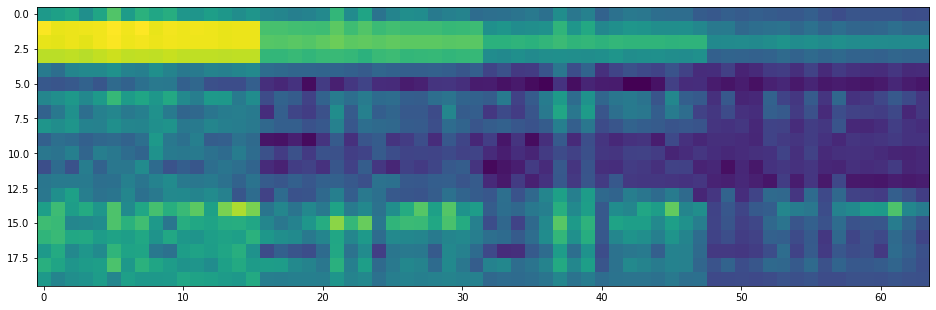

In [21]:
df_ft0 = pd.DataFrame(feat_matrix0)
plt.figure(figsize=(16, 32)) 
plt.imshow(df_ft0.values)

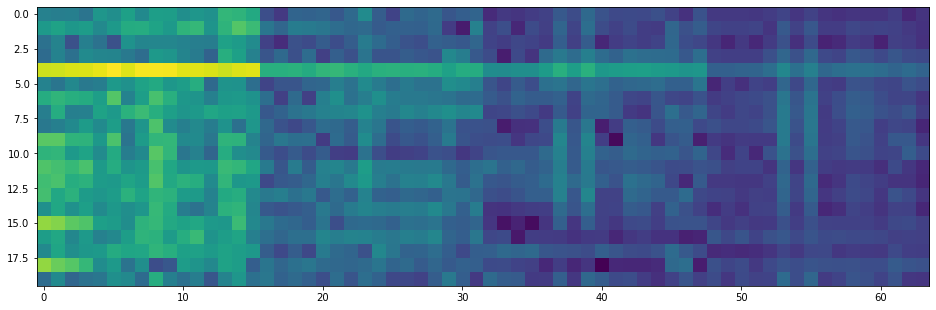

In [22]:
df_ft1 = pd.DataFrame(feat_matrix1)
plt.figure(figsize=(16, 32)) 
plt.imshow(df_ft1.values)

El eje horizontal se divide en las frecuencias:    

Delta <4    
Theta 4-8    
Alpha 8-12    
Beta 12-30    

Y a su vez cada banda se divide en los 16 canales.    
El eje vertival representa el teimpo (20 ecpoch a 1 epoch/s).    
En las ondas beta vemos como dos electrodos varían en OA y OC a lo largo del eje temporal. 



In [0]:
"""
Exercise 2: A basic Brain-Computer Interface
=============================================
Description:
In this second exercise, we will learn how to use an automatic algorithm to
recognize somebody's mental states from their EEG. We will use a classifier,
i.e., an algorithm that, provided some data, learns to recognize patterns,
and can then classify similar unseen information.
"""

import argparse
import numpy as np  # Module that simplifies computations on matrices
import matplotlib.pyplot as plt  # Module used for plotting
from pylsl import StreamInlet, resolve_byprop  # Module to receive EEG data

#import bci_workshop_tools as BCIw  # Our own functions for the workshop


if __name__ == "__main__":

    """ 0. PARSE ARGUMENTS """
    parser = argparse.ArgumentParser(description='BCI Workshop example 2')
    parser.add_argument('channels', metavar='N', type=int, nargs='*',
        default=[0, 1, 2, 3],
        help='channel number to use. If not specified, all the channels are used')

    args = parser.parse_args()

    """ 1. CONNECT TO EEG STREAM """

    # Search for active LSL stream
    print('Looking for an EEG stream...')
    streams = resolve_byprop('type', 'EEG', timeout=2)
    if len(streams) == 0:
        raise RuntimeError('Can\'t find EEG stream.')

    # Set active EEG stream to inlet and apply time correction
    print("Start acquiring data")
    inlet = StreamInlet(streams[0], max_chunklen=12)
    eeg_time_correction = inlet.time_correction()

    # Get the stream info, description, sampling frequency, number of channels
    info = inlet.info()
    description = info.desc()
    fs = int(info.nominal_srate())
    n_channels = info.channel_count()

    # Get names of all channels
    ch = description.child('channels').first_child()
    ch_names = [ch.child_value('label')]
    for i in range(1, n_channels):
        ch = ch.next_sibling()
        ch_names.append(ch.child_value('label'))

    """ 2. SET EXPERIMENTAL PARAMETERS """

    # Length of the EEG data buffer (in seconds)
    # This buffer will hold last n seconds of data and be used for calculations
    buffer_length = 15

    # Length of the epochs used to compute the FFT (in seconds)
    epoch_length = 1

    # Amount of overlap between two consecutive epochs (in seconds)
    overlap_length = 0.8

    # Amount to 'shift' the start of each next consecutive epoch
    shift_length = epoch_length - overlap_length

    # Index of the channel (electrode) to be used
    # 0 = left ear, 1 = left forehead, 2 = right forehead, 3 = right ear
    index_channel = args.channels
    # Name of our channel for plotting purposes
    ch_names = [ch_names[i] for i in index_channel]
    n_channels = len(index_channel)

    # Get names of features
    # ex. ['delta - CH1', 'pwr-theta - CH1', 'pwr-alpha - CH1',...]
    feature_names = BCIw.get_feature_names(ch_names)

    # Number of seconds to collect training data for (one class)
    training_length = 20

    """ 3. RECORD TRAINING DATA """

    # Record data for mental activity 0
    BCIw.beep()
    eeg_data0, timestamps0 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data0 = np.array(eeg_data0)[:, index_channel]

    print('\nClose your eyes!\n')

    # Record data for mental activity 1
    BCIw.beep()  # Beep sound
    eeg_data1, timestamps1 = inlet.pull_chunk(
            timeout=training_length+1, max_samples=fs * training_length)
    eeg_data1 = np.array(eeg_data1)[:, index_channel]

    # Divide data into epochs
    eeg_epochs0 = BCIw.epoch(eeg_data0, epoch_length * fs,
                             overlap_length * fs)
    eeg_epochs1 = BCIw.epoch(eeg_data1, epoch_length * fs,
                             overlap_length * fs)

    """ 4. COMPUTE FEATURES AND TRAIN CLASSIFIER """

    feat_matrix0 = BCIw.compute_feature_matrix(eeg_epochs0, fs)
    feat_matrix1 = BCIw.compute_feature_matrix(eeg_epochs1, fs)

    [classifier, mu_ft, std_ft, score] = BCIw.train_classifier(
            feat_matrix0, feat_matrix1, 'SVM')

    print(str(score * 100) + '% correctly predicted')

    BCIw.beep()

    """ 5. USE THE CLASSIFIER IN REAL-TIME"""

    # Initialize the buffers for storing raw EEG and decisions
    eeg_buffer = np.zeros((int(fs * buffer_length), n_channels))
    filter_state = None  # for use with the notch filter
    decision_buffer = np.zeros((30, 1))

    plotter_decision = BCIw.DataPlotter(30, ['Decision'])

    # The try/except structure allows to quit the while loop by aborting the
    # script with <Ctrl-C>
    print('Press Ctrl-C in the console to break the while loop.')

    try:
        while True:

            """ 3.1 ACQUIRE DATA """
            # Obtain EEG data from the LSL stream
            eeg_data, timestamp = inlet.pull_chunk(
                    timeout=1, max_samples=int(shift_length * fs))

            # Only keep the channel we're interested in
            ch_data = np.array(eeg_data)[:, index_channel]

            # Update EEG buffer
            eeg_buffer, filter_state = BCIw.update_buffer(
                    eeg_buffer, ch_data, notch=True,
                    filter_state=filter_state)

            """ 3.2 COMPUTE FEATURES AND CLASSIFY """
            # Get newest samples from the buffer
            data_epoch = BCIw.get_last_data(eeg_buffer,
                                            epoch_length * fs)

            # Compute features
            feat_vector = BCIw.compute_feature_vector(data_epoch, fs)
            y_hat = BCIw.test_classifier(classifier,
                                         feat_vector.reshape(1, -1), mu_ft,
                                         std_ft)
            print(y_hat)

            decision_buffer, _ = BCIw.update_buffer(decision_buffer,
                                                    np.reshape(y_hat, (-1, 1)))

            """ 3.3 VISUALIZE THE DECISIONS """
            plotter_decision.update_plot(decision_buffer)
            plt.pause(0.00001)

    except KeyboardInterrupt:

        print('Closed!')

usage: ipykernel_launcher.py [-h] [N [N ...]]
ipykernel_launcher.py: error: argument N: invalid int value: '/root/.local/share/jupyter/runtime/kernel-200b0441-5e33-4601-8ab7-befb86fa13d6.json'


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
